# AdaIN

Implementation of paper [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization](https://arxiv.org/pdf/1703.06868.pdf) using Tensorflow 1.x.
The dataset for content is [MS-COCO](http://cocodataset.org/#home) and the dataset for style is [wikiart](https://github.com/cs-chan/ArtGAN/tree/master/WikiArt%20Dataset)

Reference: https://github.com/ftokarev/tf-adain

## Import Libraries

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
import random 
import os 
import vgg19
import datetime 
import cv2

## Parameters

In [2]:
algorithm = 'AdaIN'

resize_dim = 512 
crop_size = 256 

batch_size = 8
train_batch = 3000

style_weight = 1.0
lr = 0.0001

show_img_step = 50

s_loss_var_list = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1']

train_model = False
load_model = True

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

save_path = 'saved_models/'+ algorithm + '/' + date_time + '/'
load_path = 'saved_models/' + algorithm + '/20200528-02-36-04/model'

## Data Path

In [3]:
content_path = "./train2017/"
style_path = "./wikiart/"
style_folders = os.listdir(style_path)

test_path_content = './test/content/'
test_path_style = './test/style/'

## AdaIN

In [4]:
tf.get_default_graph() 

vgg = vgg19.VGG19('./imagenet-vgg-verydeep-19.mat')

class Model():
    def __init__(self):
        self.input_c = tf.placeholder(tf.float32, [None, None, None, 3])
        self.input_s = tf.placeholder(tf.float32, [None, None, None, 3])
        
        self.input_c_norm = 2*(self.input_c-0.5)
        self.input_s_norm = 2*(self.input_s-0.5)
        
        self.alpha = tf.placeholder(tf.float32, [1])
        
        self.net_c = vgg.feed_forward(self.input_c_norm, scope='Encoder')
        self.net_s = vgg.feed_forward(self.input_s_norm, scope='Encoder')
        
        self.t = self.AdaIN(self.net_c['relu4_1'], self.net_s['relu4_1'])
        self.t_weight = ((1-self.alpha) * self.net_c['relu4_1']) + (self.alpha * self.t)
        
        self.out_img = self.Decoder(self.t_weight)
        
        # Get Loss
        self.net_g = vgg.feed_forward(self.out_img, scope='Encoder')
        self.loss_c = tf.reduce_mean(tf.abs(self.net_g['relu4_1']-self.t))
        
        self.loss_s = 0
        for s_var in s_loss_var_list:
            mean_g, var_g = tf.nn.moments(self.net_g[s_var], axes=[1,2], keep_dims=True)
            mean_s, var_s = tf.nn.moments(self.net_s[s_var], axes=[1,2], keep_dims=True)

            std_g, std_s = tf.sqrt(var_g + 1e-8), tf.sqrt(var_s + 1e-8)

            loss_s_mean = tf.reduce_mean(tf.abs(mean_s-mean_g))
            loss_s_std = tf.reduce_mean(tf.abs(std_s-std_g))
            
            self.loss_s += (style_weight*(loss_s_mean+loss_s_std))
        
        self.loss = self.loss_c + self.loss_s
        
        self.train_vars=tf.trainable_variables()
        Dec_vars=[var for var in self.train_vars if 'Decoder' in var.name]
        
        self.train_step=tf.train.AdamOptimizer(lr).minimize(self.loss, var_list=Dec_vars)
        
    def AdaIN(self, content, style):
        mean_c, var_c = tf.nn.moments(content, axes=[1, 2], keep_dims=True)
        mean_s, var_s = tf.nn.moments(style, axes=[1, 2], keep_dims=True)
        std_c, std_s = tf.sqrt(var_c + 1e-8), tf.sqrt(var_s + 1e-8)
        
        normalized_c = (content-mean_c)/std_c
        AdaIN_out = (std_s * normalized_c) + mean_s
        
        return AdaIN_out
    
    def Decoder(self, x):
        with tf.variable_scope('Decoder', reuse=tf.AUTO_REUSE):
            conv1_1 = tf.layers.conv2d(x, filters=512, activation=tf.nn.relu, kernel_size=3, strides=1, padding="same")
            size1 = 2*tf.shape(conv1_1)[1]
            up1 = tf.image.resize_nearest_neighbor(conv1_1, [size1,size1])

            conv2_1 = tf.layers.conv2d(up1, filters=256, activation=tf.nn.relu, 
                                       kernel_size=3, strides=1, padding="same")
            conv2_2 = tf.layers.conv2d(conv2_1, filters=256, activation=tf.nn.relu, 
                                       kernel_size=3, strides=1, padding="same")
            conv2_3 = tf.layers.conv2d(conv2_2, filters=256, activation=tf.nn.relu, 
                                       kernel_size=3, strides=1, padding="same")

            size2 = 2*tf.shape(conv2_3)[1]
            up2 = tf.image.resize_nearest_neighbor(conv2_3, [size2,size2])

            conv3_1 = tf.layers.conv2d(up2, filters=128, activation=tf.nn.relu, 
                                       kernel_size=3, strides=1, padding="same")
            conv3_2 = tf.layers.conv2d(conv3_1, filters=128, activation=tf.nn.relu, 
                                       kernel_size=3, strides=1, padding="same")

            size3 = 2*tf.shape(conv3_2)[1]
            up3 = tf.image.resize_nearest_neighbor(conv3_2, [size3,size3])

            conv4_1 = tf.layers.conv2d(up3, filters=64, activation=tf.nn.relu, 
                                       kernel_size=3, strides=1, padding="same")
            conv4_2 = tf.layers.conv2d(conv4_1, filters=64, activation=tf.nn.relu, 
                                       kernel_size=3, strides=1, padding="same")

            output = tf.layers.conv2d(conv4_2, filters=3, activation=tf.nn.tanh, 
                                      kernel_size=1, strides=1, padding="same")
        
        return output 


## Init Session

In [5]:
model = Model()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
init = tf.global_variables_initializer()
sess.run(init)

Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

INFO:tensorflow:Restoring parameters from saved_models/AdaIN/20200528-02-36-04/model


## Train

In [12]:
def random_crop_image(img):
    # Resize image for crop
    if img.shape[0]<img.shape[1]:
        img = cv2.resize(img, (int((img.shape[1]/img.shape[0])*resize_dim), resize_dim))
    else:
        img = cv2.resize(img, (resize_dim, int((img.shape[0]/img.shape[1])*resize_dim)))          

    # Crop the image 
    crop_img = np.zeros([crop_size, crop_size, 3])
    
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    h_end = img_h - crop_size
    w_end =  img_w - crop_size
    
    h_start = np.random.randint(h_end)
    w_start = np.random.randint(w_end)
            
    crop_img = img[h_start:h_start+crop_size, w_start:w_start+crop_size, :]
    
    return crop_img
 
def get_img(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    return img 
    
def get_content_batch(data_size, img_size, is_crop):
    content_batch = np.zeros([data_size, img_size, img_size, 3])
    
    content_path_list = []
    for i in range(data_size):
        content_batch_path = random.sample(os.listdir(content_path), 1)[0]
        c_img = get_img(content_path + content_batch_path)
        content_path_list.append(content_path + content_batch_path)
                
        if is_crop:
            c_img = random_crop_image(c_img)

        content_batch[i,:] = c_img/255.0
    
    return content_batch, content_path_list    
    
def get_style_batch(data_size, img_size, is_crop):
    style_batch_path = []
    style_batch = np.zeros([data_size, img_size, img_size, 3])
        
    for i in range(data_size):
        s_folder_path = random.sample(style_folders, 1)[0]
        s_file_path = random.sample(os.listdir(style_path+s_folder_path),1)[0]

        style_path_full = style_path + s_folder_path + '/' + s_file_path
        style_batch_path.append(style_path_full)
        s_img = get_img(style_path_full)
            
        if is_crop:
            s_img = random_crop_image(s_img)

        style_batch[i,:] = s_img/255.0
    
    return style_batch, style_batch_path   

def get_test(c_idx, s_idx):
    c_file_path = test_path_content + os.listdir(test_path_content)[c_idx]
    s_file_path = test_path_style + os.listdir(test_path_style)[s_idx]
    
    c_img = get_img(c_file_path)
    s_img = get_img(s_file_path)
    
    c_img = cv2.resize(c_img, (512, 512))   
    s_img = cv2.resize(s_img, (512, 512)) 
    
    c_img = c_img/255.0
    s_img = s_img/255.0
    
    return c_img, s_img
    

Text(0.5,1,'Style Sample')

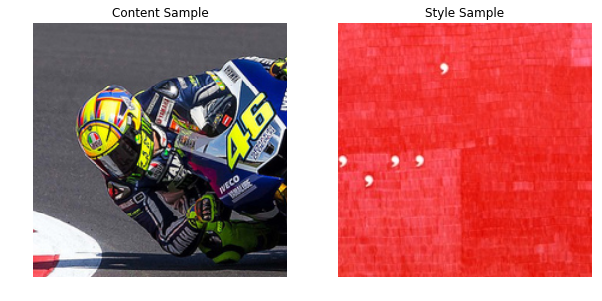

In [7]:
content_sample, _ = get_content_batch(1, crop_size, True)
style_sample, _ = get_style_batch(1, crop_size, True)

fig, ax = plt.subplots(1,2, figsize=[10,10])

ax[0].imshow(content_sample[0])
ax[0].axis("off")
ax[0].set_title('Content Sample')
ax[1].imshow(style_sample[0])
ax[1].axis("off")
ax[1].set_title('Style Sample')

In [8]:
if train_model:
    c_loss_list = []
    s_loss_list = []
    for i in range(train_batch):
        content_batch, content_path_ = get_content_batch(batch_size, crop_size, True)
        style_batch, style_path_ = get_style_batch(batch_size, crop_size, True)

        _, out_img, c_loss, s_loss = sess.run([model.train_step, model.out_img, model.loss_c, model.loss_s], feed_dict={
                                               model.input_c: content_batch, model.input_s: style_batch, model.alpha: [1.0]})
        
        c_loss_list.append(c_loss)
        s_loss_list.append(s_loss)
        
        print("Batch step: {} / {}".format(i, train_batch), end='\r')
        
        if i % show_img_step == 0:
            print("Batch: {} / C loss: {:.4f} / S loss: {:.4f}".format(i, np.mean(c_loss_list), np.mean(s_loss_list)))
            
            c_loss_list = []
            s_loss_list = []
            
            fig, ax = plt.subplots(1,3, figsize=[10,10])

            ax[0].imshow(content_batch[0])
            ax[0].axis("off")
            ax[0].set_title('Content')
            ax[1].imshow(style_batch[0])
            ax[1].axis("off")
            ax[1].set_title('Style')
            ax[2].imshow((out_img[0]+1)/2)
            ax[2].axis("off")
            ax[2].set_title('Result')
            
            plt.show()

## Test (Result)

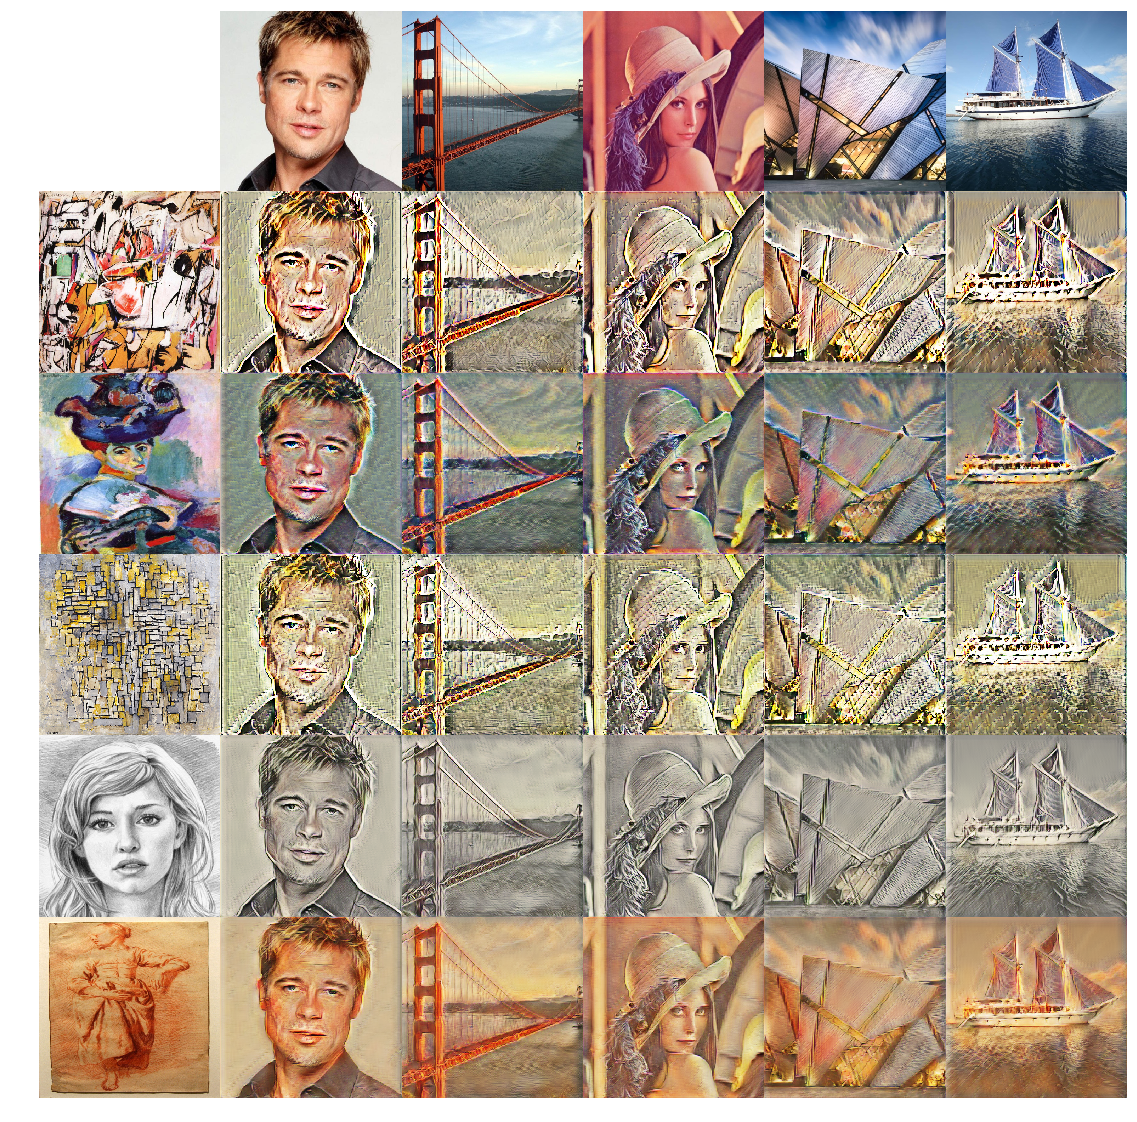

In [16]:
num_test = 5

c_test_list = [2, 6, 7, 8, 10]
s_test_list = [1, 19, 9, 14, 17]

result_img = np.ones([512*(num_test+1), 512*(num_test+1), 3])

for i in range(num_test):
    test_content_sample, test_style_sample = get_test(c_test_list[i], s_test_list[i])
    
    result_img[0:512, (i+1)*512:(i+2)*512] = test_content_sample
    result_img[(i+1)*512:(i+2)*512, 0:512] = test_style_sample

for i in range(num_test**2):
    row = int(i/num_test)
    col = int(i%num_test)
        
    test_content_sample, test_style_sample = get_test(c_test_list[col], s_test_list[row])
    
    out_img = sess.run([model.out_img], feed_dict={model.input_c: [test_content_sample], 
                                                   model.input_s: [test_style_sample], model.alpha: [1]})
    
    result_img[(row+1)*512:(row+2)*512, (col+1)*512:(col+2)*512] = (out_img[0]+1)/2

plt.figure(figsize=(20,20))
plt.imshow(result_img)
plt.axis("off")
plt.show()

## Test (Interpolation)

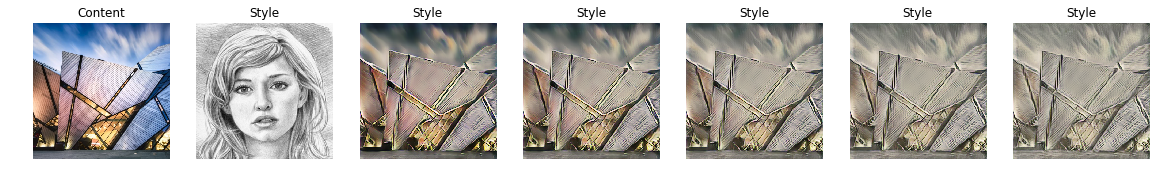

In [21]:
test_content_sample, test_style_sample = get_test(8, 14)

fig, ax = plt.subplots(1,7, figsize=[20,20])

ax[0].imshow(test_content_sample)
ax[0].axis("off")
ax[0].set_title('Content')
ax[1].imshow(test_style_sample)
ax[1].axis("off")
ax[1].set_title('Style')

for i in range(5):
    alpha = i/4
    
    out_img = sess.run([model.out_img], feed_dict={model.input_c: [test_content_sample], 
                                               model.input_s: [test_style_sample], model.alpha: [alpha]})

    ax[2+i].imshow((out_img[0][0]+1)/2)
    ax[2+i].axis("off")
    ax[2+i].set_title('Style')

## Save Model

In [ ]:
Saver.save(sess, save_path + "/model")
print("Saved Path: {}".format(save_path + "/model"))